In [1]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

Using TensorFlow backend.


In [2]:
#Import data
df = pd.read_csv('data/train_sample.csv', header = 0)

In [3]:
#Check num of cases in label 
print(df.is_attributed.value_counts()) #very imbalanced data set

0    99773
1      227
Name: is_attributed, dtype: int64


In [4]:
#---------------------------Pre-processing-------------------------
#Create new variables
df['ip_cut'] = pd.cut(df.ip,15)
df['time_interval'] = df.click_time.str[11:13]

#Drop unneeded variables
df = df.drop(['ip', 'attributed_time', 'click_time'], axis = 1)

In [5]:
#Encode categorical variables to ONE-HOT
categorical_columns = ['app', 'device', 'os', 'channel', 'ip_cut', 'time_interval']

df = pd.get_dummies(df, columns = categorical_columns)

In [6]:
#Split in 75% train and 25% test set
train_df, test_df = train_test_split(df, test_size = 0.25, random_state= 1984)

#Make sure labels are equally distributed in train and test set
train_df.is_attributed.sum()/train_df.shape[0] #0.2233
test_df.is_attributed.sum()/test_df.shape[0] #0.2148

#Get the data ready for the Neural Network
train_y = train_df.is_attributed
test_y = test_df.is_attributed

train_x = train_df.drop(['is_attributed'], axis = 1)
test_x = test_df.drop(['is_attributed'], axis = 1)

train_x =np.array(train_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
test_y = np.array(test_y)

In [7]:
#-------------------Build the Neural Network model-------------------
print('Building Neural Network model...')
adam = optimizers.adam(lr = 0.005, decay = 0.0000001)

model = Sequential()
model.add(Dense(48, input_dim=train_x.shape[1],
                kernel_initializer='normal',
                #kernel_regularizer=regularizers.l2(0.02),
                activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(24,
                #kernel_regularizer=regularizers.l2(0.02),
                activation="tanh"))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss="binary_crossentropy", optimizer='adam')

history = model.fit(train_x, train_y, validation_split=0.2, epochs=3, batch_size=64)

Building Neural Network model...
Train on 60000 samples, validate on 15000 samples
Epoch 1/3
60000/60000 [==============================] - 3s 54us/step - loss: 0.0262 - val_loss: 0.0083
Epoch 2/3
60000/60000 [==============================] - 3s 51us/step - loss: 0.0080 - val_loss: 0.0074
Epoch 3/3
60000/60000 [==============================] - 3s 49us/step - loss: 0.0063 - val_loss: 0.0071


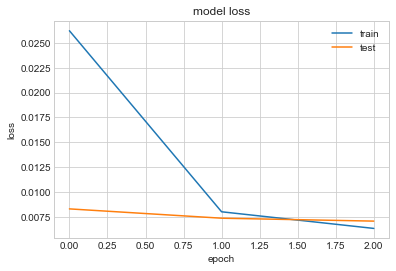

In [8]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [9]:
#Predict on test set
predictions_NN_prob = model.predict(test_x)
predictions_NN_prob = predictions_NN_prob[:,0]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

In [10]:
#Print accuracy
acc_NN = accuracy_score(test_y, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)

Overall accuracy of Neural Network model: 0.99804


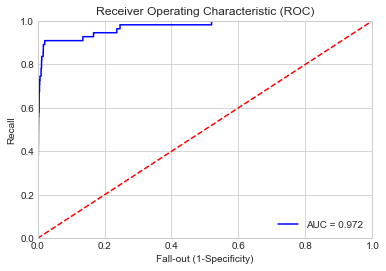

In [11]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

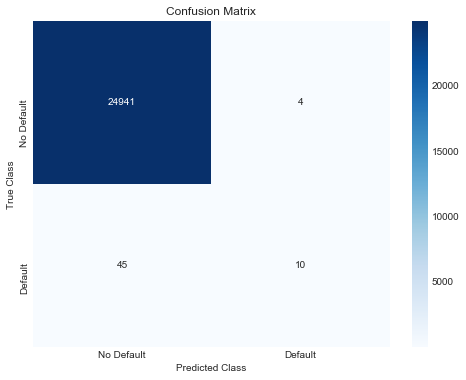

In [12]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()